In [5]:
import requests
from IPython.display import Markdown
from tqdm import tqdm, tqdm_notebook
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import altair as alt
from requests.utils import quote
import os
from github import Github
from datetime import timedelta

In [6]:
end_date = "2019-07-01"
start_date = "2019-05-01"
renderer = "jupyterlab"

In [7]:
# Create the renderer we want
alt.renderers.enable(renderer)

RendererRegistry.enable('jupyterlab')

In [8]:
# Discourse API key
api = {'Api-Key': os.environ['DISCOURSE_API_KEY'],
       'Api-Username': os.environ['DISCOURSE_API_USERNAME']}

In [9]:
gh = Github(os.environ["GITHUB_ACCESS_TOKEN"])

In [10]:
# Discourse
def topics_to_markdown(topics, n_list=10):
    body = []
    for _, topic in topics.iterrows():
        title = topic['fancy_title']
        slug = topic['slug']
        posts_count = topic['posts_count']
        url = f'https://discourse.jupyter.org/t/{slug}'
        body.append(f'* [{title}]({url}) ({posts_count} posts)')
    body = body[:n_list]
    return '\n'.join(body)

def counts_from_activity(activity):
    counts = activity.groupby('category_id').count()['bookmarked'].reset_index()
    counts['parent_category'] = None
    for ii, irow in counts.iterrows():
        if parent_categories[irow['category_id']] is not None:
            counts.loc[ii, 'parent_category'] = parent_categories[irow['category_id']]

    counts['category_id'] = counts['category_id'].map(lambda a: category_mapping[a])
    counts['parent_category'] = counts['parent_category'].map(lambda a: category_mapping[a] if a is not None else 'parent')
    is_parent = counts['parent_category'] == 'parent'
    counts.loc[is_parent, 'parent_category'] = counts.loc[is_parent, 'category_id'] 
    counts['parent/category'] = counts.apply(lambda a: a['parent_category']+'/'+a['category_id'], axis=1)
    counts = counts.sort_values(['parent_category', 'bookmarked'], ascending=False)
    return counts

# GitHub
def run_github_query(query, github_base="https://api.github.com/search/issues"):
    gh = Github(os.environ["GITHUB_ACCESS_TOKEN"])
    resp = gh.search_issues(query)
    data = []
    for ii in range(0, 10):
        items = resp.get_page(ii)
        if len(items) > 0:
            items_list = [item.raw_data for item in items]
            data.append(pd.DataFrame.from_records(items_list))
        else:
            break
    if len(data) == 0:
        return pd.DataFrame([])
    else:
        return pd.concat(data)
    

# Community forum activity

The [Jupyter Community Forum](https://discourse.jupyter.org) is a place for Jovyans across the
community to talk about Jupyter tools in interactive computing and how they fit into their
workflows. It's also a place for developers to share ideas, tools, tips, and help one another.

Below are a few updates from activity in the Discourse. For more detailed information about
the activity on the Community Forum, check out these links:

* [The users page](https://discourse.jupyter.org/u) has information about user activity
* [The top posts page](https://discourse.jupyter.org/top) contains a list of top posts, sorted
  by various metrics.

In [11]:
# Get categories for IDs
url = "https://discourse.jupyter.org/site.json"
resp = requests.get(url, headers=api)
category_mapping = {cat['id']: cat['name'] for cat in resp.json()['categories']}
parent_categories = {cat['id']: cat.get("parent_category_id", None) for cat in resp.json()['categories']}

In [12]:
# Base URL to use
url = "https://discourse.jupyter.org/latest.json"

## Topics with lots of likes

"Likes" are a way for community members to say thanks for a helpful post, show their
support for an idea, or generally to share a little positivity with somebody else.
These are topics that have generated lots of likes in recent history.

In [13]:
params = {"order": "likes", "ascending": "False"}
resp = requests.get(url, headers=api, params=params)

# Topics with the most likes in recent history
liked = pd.DataFrame(resp.json()['topic_list']['topics'])
Markdown(topics_to_markdown(liked))

* [Introduce yourself!](https://discourse.jupyter.org/t/introduce-yourself) (98 posts)
* [{WIP} Re-Design of Jupyter.org Website](https://discourse.jupyter.org/t/wip-re-design-of-jupyter-org-website) (39 posts)
* [Jupyter Community Calls](https://discourse.jupyter.org/t/jupyter-community-calls) (28 posts)
* [Help us choose an updated &ldquo;Launch Binder&rdquo; badge!](https://discourse.jupyter.org/t/help-us-choose-an-updated-launch-binder-badge) (21 posts)
* [JupyterHub, Binder workshop](https://discourse.jupyter.org/t/jupyterhub-binder-workshop) (12 posts)
* [The Binder Federation](https://discourse.jupyter.org/t/the-binder-federation) (14 posts)
* [PyCon 2019 and mybinder.org](https://discourse.jupyter.org/t/pycon-2019-and-mybinder-org) (17 posts)
* [Jupyter community workshop: proposal on diversity, inclusion and accessibility](https://discourse.jupyter.org/t/jupyter-community-workshop-proposal-on-diversity-inclusion-and-accessibility) (20 posts)
* [Sunset the GitHub repo jupyter/help?](https://discourse.jupyter.org/t/sunset-the-github-repo-jupyter-help) (17 posts)
* [Reviving the all-Jupyter community meetings](https://discourse.jupyter.org/t/reviving-the-all-jupyter-community-meetings) (17 posts)

## Active topics on Discourse

These are topics with lots of activity in recent history.

In [14]:
params = {"order": "posts", "ascending": "False"}
resp = requests.get(url, headers=api, params=params)

# Topics with the most posts in recent history
posts = pd.DataFrame(resp.json()['topic_list']['topics'])
Markdown(topics_to_markdown(posts))

* [Introduce yourself!](https://discourse.jupyter.org/t/introduce-yourself) (98 posts)
* [Tip: embed custom github content in a Binder link with nbgitpuller](https://discourse.jupyter.org/t/tip-embed-custom-github-content-in-a-binder-link-with-nbgitpuller) (40 posts)
* [{WIP} Re-Design of Jupyter.org Website](https://discourse.jupyter.org/t/wip-re-design-of-jupyter-org-website) (39 posts)
* [Would a &ldquo;The Littlest Binder&rdquo; be useful?](https://discourse.jupyter.org/t/would-a-the-littlest-binder-be-useful) (31 posts)
* [Plugins of considerations](https://discourse.jupyter.org/t/plugins-of-considerations) (28 posts)
* [Jupyter Community Calls](https://discourse.jupyter.org/t/jupyter-community-calls) (28 posts)
* [A proposal for JupyterHub communications](https://discourse.jupyter.org/t/a-proposal-for-jupyterhub-communications) (26 posts)
* [Binder/BinderHub Workshops &ndash; Help Wanted!](https://discourse.jupyter.org/t/binder-binderhub-workshops-help-wanted) (25 posts)
* [Rename this category to Jupyter Server?](https://discourse.jupyter.org/t/rename-this-category-to-jupyter-server) (21 posts)
* [Potential collaboration on user research?](https://discourse.jupyter.org/t/potential-collaboration-on-user-research) (21 posts)

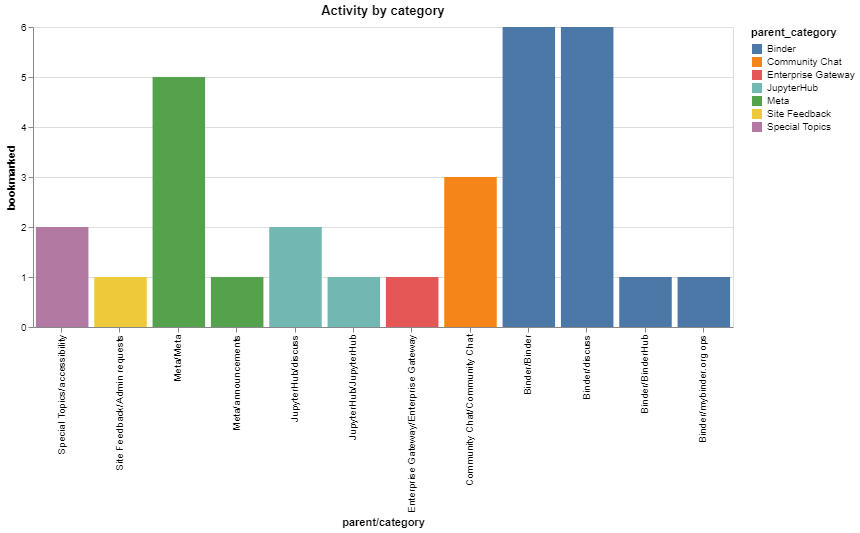

In [15]:
counts = counts_from_activity(posts)
alt.Chart(data=counts, width=700, height=300, title="Activity by category").mark_bar().encode(
    x=alt.X("parent/category", sort=alt.Sort(counts['category_id'].values.tolist())),
    y="bookmarked",
    color="parent_category"
)

## Recently-created topics

These are topics that were recently created, sorted by the amount of activity
in each one.

In [16]:
params = {"order": "created", "ascending": "False"}
resp = requests.get(url, headers=api, params=params)

# Sort created by the most posted for recently-created posts
created = pd.DataFrame(resp.json()['topic_list']['topics'])
created = created.sort_values('posts_count', ascending=False)
Markdown(topics_to_markdown(created))

* [Automatic HTTPS with LetsEncrypt in the context of Binder](https://discourse.jupyter.org/t/automatic-https-with-letsencrypt-in-the-context-of-binder) (12 posts)
* [Creating environment.yml for Python 2 via Binder](https://discourse.jupyter.org/t/creating-environment-yml-for-python-2-via-binder) (11 posts)
* [Can I serve notebooks from my own server?](https://discourse.jupyter.org/t/can-i-serve-notebooks-from-my-own-server) (9 posts)
* [Binderhub button - &lsquo;pull from referrer&rsquo;](https://discourse.jupyter.org/t/binderhub-button-pull-from-referrer) (9 posts)
* [Why does nb2kg connect to the kernel via EG rather than directly?](https://discourse.jupyter.org/t/why-does-nb2kg-connect-to-the-kernel-via-eg-rather-than-directly) (6 posts)
* [&ldquo;Astronomy Picture of the Day&rdquo; tutorial problem. Version mismatch?](https://discourse.jupyter.org/t/astronomy-picture-of-the-day-tutorial-problem-version-mismatch) (5 posts)
* [Cells not importing modules anymore](https://discourse.jupyter.org/t/cells-not-importing-modules-anymore) (5 posts)
* [HTTPS with Let&rsquo;s Encrypt on JupyterHub in Kubernetes](https://discourse.jupyter.org/t/https-with-lets-encrypt-on-jupyterhub-in-kubernetes) (4 posts)
* [Jupyter-server-proxy Gallery?](https://discourse.jupyter.org/t/jupyter-server-proxy-gallery) (4 posts)
* [Is there a way for proxying an internal web service in a cell? (specially when in a binderhub)](https://discourse.jupyter.org/t/is-there-a-way-for-proxying-an-internal-web-service-in-a-cell-specially-when-in-a-binderhub) (3 posts)

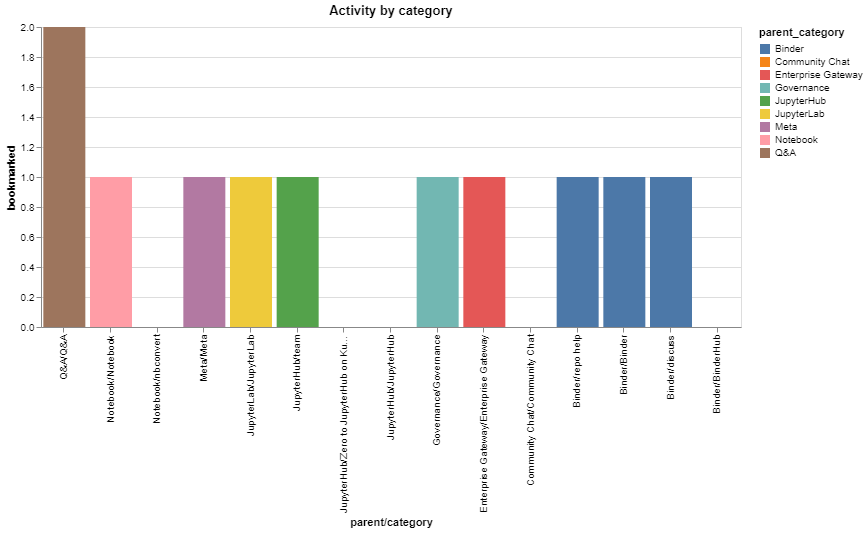

In [17]:
counts = counts_from_activity(created)
alt.Chart(data=counts, width=700, height=300, title="Activity by category").mark_bar().encode(
    x=alt.X("parent/category", sort=alt.Sort(counts['category_id'].values.tolist())),
    y="bookmarked",
    color="parent_category"
)

## User activity in Discourse

These are the top posters and top "like-ers" in the Discourse

In [18]:
def plot_user_data(users, column):
    plt_data = users.sort_values(column, ascending=False).head(50)
    ch = alt.Chart(data=plt_data).mark_bar().encode(
        x=alt.X("username", sort=plt_data['username'].tolist()),
        y=column
    )
    return ch

In [19]:
url = "https://discourse.jupyter.org/directory_items.json"
params = {"period": "quarterly", "order": "post_count"}
resp = requests.get(url, headers=api, params=params)

# Topics with the most likes in recent history
users = pd.DataFrame(resp.json()['directory_items'])
users['username'] = users['user'].map(lambda a: a['username'])

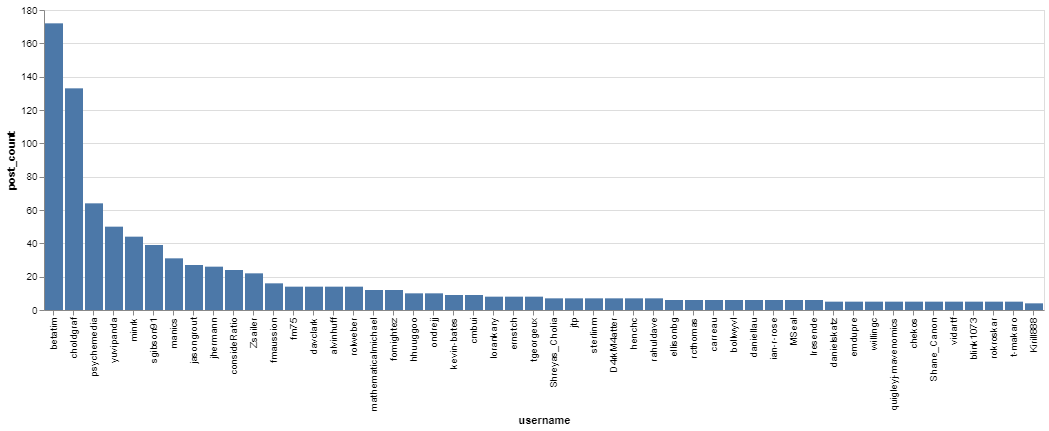

In [20]:
plot_user_data(users.head(50), 'post_count')

**Discourse users sorted by likes given**

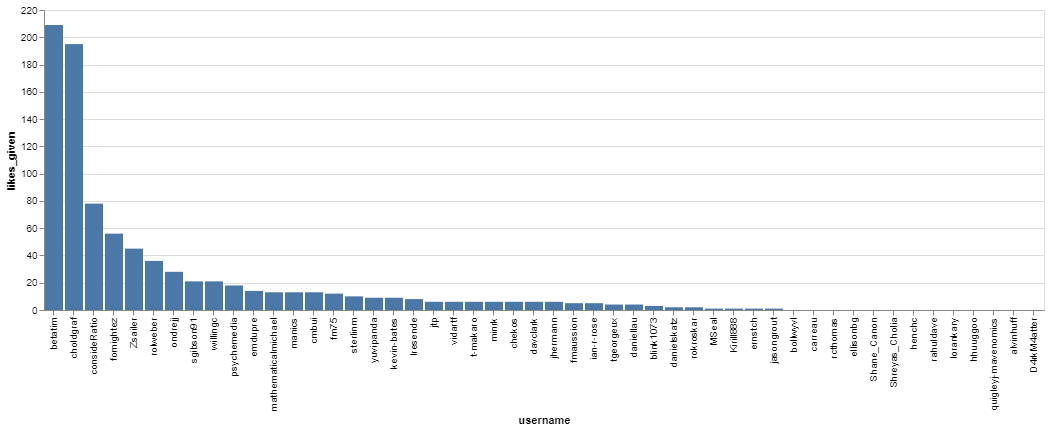

In [21]:
plot_user_data(users.head(50), 'likes_given')

**Discourse users sorted by likes given**

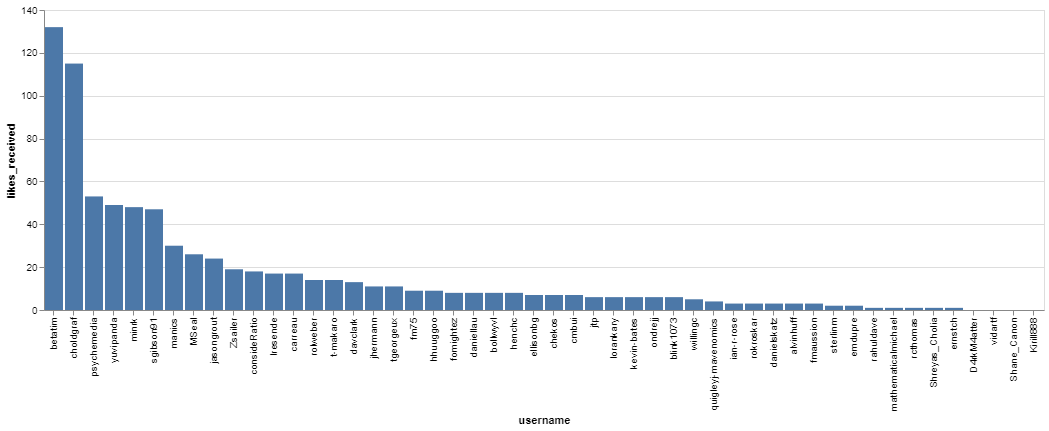

In [22]:
plot_user_data(users.head(50), 'likes_received')

# GitHub activity

Jupyter also has lots of activity across GitHub repositories. The following sections contain
overviews of recent activity across the following GitHub organizations:

In [23]:
from datetime import timedelta

orgs = ["jupyterhub", "jupyter", "jupyterlab", "jupyter-widgets", "ipython", "binder-examples"]
orgs_md = []
for org in orgs:
    orgs_md.append(f'* [github.com/{org}](https://github.com/{org})')
Markdown('\n'.join(orgs_md))

* [github.com/jupyterhub](https://github.com/jupyterhub)
* [github.com/jupyter](https://github.com/jupyter)
* [github.com/jupyterlab](https://github.com/jupyterlab)
* [github.com/jupyter-widgets](https://github.com/jupyter-widgets)
* [github.com/ipython](https://github.com/ipython)
* [github.com/binder-examples](https://github.com/binder-examples)

In [24]:
Markdown(f"Showing GitHub activity from **{start_date}** to **{end_date}**")

Showing GitHub activity from **2019-05-01** to **2019-07-01**

In [25]:
# Define our query object that we'll re-use for github search
class GitHubGraphQlQuery():
    def __init__(self, query):
        self.query = query
        self.headers = {"Authorization": "Bearer %s" % os.environ['GITHUB_ACCESS_TOKEN']}
        self.gql_template = """
{
  search(%s) {
    issueCount
    pageInfo {
        endCursor
        hasNextPage
    }
    nodes {
      ... on PullRequest {
        state
        id
        title
        url
        createdAt
        updatedAt
        number
        author {
          login
          url
        }
        mergedBy {
          login
          url
        }
        comments(last: 15) {
          edges {
            node {
              authorAssociation
              createdAt
              lastEditedAt
              url
              repository {
                id
              }
              author {
                login
                url
              }
            }
          }
        }
      }
      ... on Issue {
        url
        title
        state
        createdAt
        updatedAt
        number
        author {
          login
          url
        }
        comments(last: 15) {
          edges {
            node {
              author {
                login
                url
              }
              authorAssociation
              createdAt
              lastEditedAt
              repository {
                id
              }
              url
            }
          }
        }
      }
    }
  }
}
"""
    def request(self, n_pages=100, n_per_page=50):
        self.raw_data = []
        for ii in range(n_pages):
            search_query = ["first: %s" % n_per_page, 'query: "%s"' % self.query, 'type: ISSUE']
            if ii != 0:
                search_query.append('after: "%s"' % pageInfo['endCursor'])

            this_query = self.gql_template % ', '.join(search_query)
            request = requests.post('https://api.github.com/graphql', json={'query': this_query}, headers=self.headers)
            if request.status_code != 200:
                raise Exception("Query failed to run by returning code of {}. {}".format(request.status_code, this_query))
            if "errors" in request.json().keys():
                raise Exception("Query failed to run with error {}. {}".format(request.json()['errors'], this_query))
            self.request = request

            # Parse the response
            json = request.json()['data']['search']
            if ii == 0:
                print("Found {} items, which will take {} pages".format(json['issueCount'], int(np.ceil(json['issueCount'] / n_per_page))))
            self.raw_data.append(json)
            pageInfo = json['pageInfo']
            self.last_query = this_query
            if pageInfo['hasNextPage'] is False:
                break
        
        if self.raw_data[0]['issueCount'] == 0:
            print("Found no entries for query {}".format(self.query))
            self.data = None
            return
        
        # Add some extra fields
        self.data = pd.DataFrame([jj for ii in self.raw_data for jj in ii['nodes']])
        self.data['username'] = self.data['author'].map(lambda a: a['login'])
        self.data['username_url'] = self.data['author'].map(lambda a: a['url'])
        self.data['org'] = self.data['url'].map(lambda a: a.split('/')[3])
        self.data['repo'] = self.data['url'].map(lambda a: a.split('/')[4])

In [26]:
responses = []
for org in orgs:
    query_prs = f"is:merged user:{org} archived:false closed:{start_date}..{end_date}"
    ghq = GitHubGraphQlQuery(query_prs)
    ghq.request()
    if ghq.data is None:
        continue
    responses.append(ghq)
    
merged = pd.concat([ii.data for ii in responses])

Found 238 items, which will take 5 pages
Found 248 items, which will take 5 pages
Found 211 items, which will take 5 pages
Found 79 items, which will take 2 pages
Found 53 items, which will take 2 pages
Found 3 items, which will take 1 pages


In [27]:
# Add a PR-specific field for closed PRs
merged['closed_by'] = merged['mergedBy'].map(lambda a: a['login'])
merged['closed_by_url'] = merged['mergedBy'].map(lambda a: a['url'])

In [28]:
prs_by_repo = merged.groupby(['org', 'repo']).count()['author'].reset_index().sort_values(['org', 'author'], ascending=False)

## Commentors

## Merged Pull requests

Here's an analysis of **merged pull requests** across each of the repositories in the Jupyter
ecosystem.

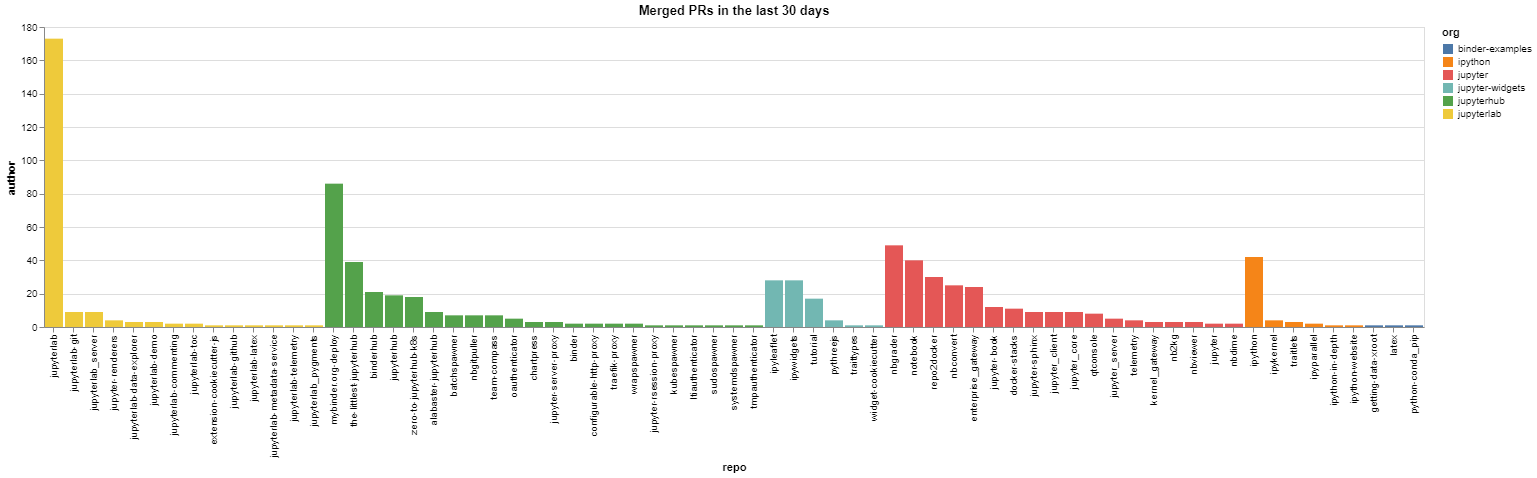

In [29]:
alt.Chart(data=prs_by_repo, title="Merged PRs in the last 30 days").mark_bar().encode(
    x=alt.X('repo', sort=prs_by_repo['repo'].values.tolist()),
    y='author',
    color='org'
)

### A list of merged PRs by project

In [30]:
from ipywidgets import widgets, HTML
from ipywidgets import HTML
from markdown import markdown 

In [31]:
tabs = widgets.Tab(children=[])
merged_by = {}
pr_by = {}
for ii, (org, idata) in enumerate(merged.groupby('org')):
    issue_md = []
    issue_md.append(f"#### Closed PRs for org: `{org}`")
    issue_md.append("")
    for (org, repo), prs in idata.groupby(['org', 'repo']):
        issue_md.append(f"##### [{org}/{repo}](https://github.com/{org}/{repo})")
        for _, pr in prs.iterrows():
            user_name = pr['username']
            user_url = pr['username_url']
            pr_number = pr['number']
            pr_html = pr['url']
            pr_title = pr['title']
            pr_closedby = pr['closed_by']
            pr_closedby_url = pr['closed_by_url']
            if user_name not in pr_by:
                pr_by[user_name] = 1
            else:
                pr_by[user_name] += 1
                
            if pr_closedby not in merged_by:
                merged_by[pr_closedby] = 1
            else:
                merged_by[pr_closedby] += 1
            text = f"* [(#{pr_number})]({pr_html}): _{pr_title}_ by **[@{user_name}]({user_url})** merged by **[@{pr_closedby}]({pr_closedby_url})**"
            issue_md.append(text)
    issue_md.append('')
    markdown_html = markdown('\n'.join(issue_md))
    
    children = list(tabs.children)
    children.append(HTML(markdown_html))
    tabs.children = tuple(children)
    tabs.set_title(ii, org)
tabs

Authoring and merging stats by repo

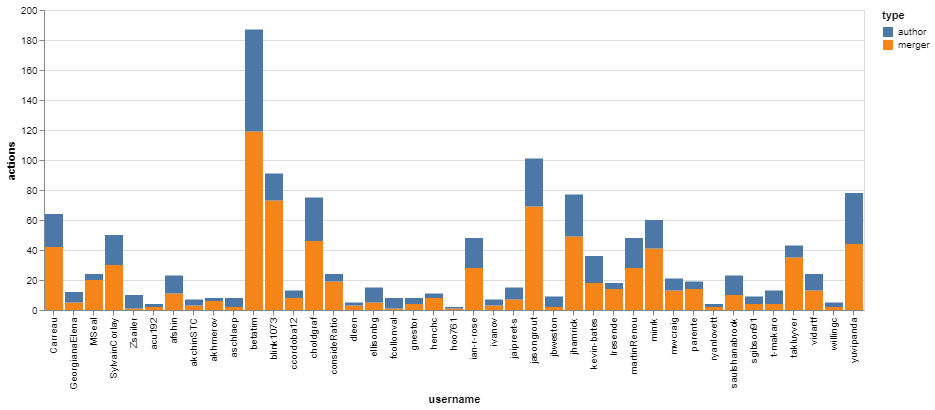

In [32]:
merged_by = pd.Series(merged_by, name='merger')
pr_by = pd.Series(pr_by, name='author')
stats = pd.merge(merged_by, pr_by, left_index=True, right_index=True)
stats.index.name = "username"
stats.columns.name = "type"
stats = stats.stack()
stats.name = "actions"
stats = stats.reset_index()
ch = alt.Chart(data=stats)
bar = ch.mark_bar().encode(
    x="username",
    y="actions",
    color="type"
)
bar

## Issues

Issues are **conversations** that happen on our GitHub repositories. Here's an
analysis of issues across the Jupyter organizations.

In [33]:
responses = []
for org in orgs:
    query_prs = f"is:open is:issue user:{org} archived:false created:{start_date}..{end_date}"
    ghq = GitHubGraphQlQuery(query_prs)
    ghq.request()
    if ghq.data is None:
        continue
    responses.append(ghq)
    
created = pd.concat([ii.data for ii in responses])
created['n_comments'] = created['comments'].map(lambda a: len(a['edges']))

Found 191 items, which will take 4 pages
Found 196 items, which will take 4 pages
Found 169 items, which will take 4 pages
Found 46 items, which will take 1 pages
Found 45 items, which will take 1 pages
Found 1 items, which will take 1 pages


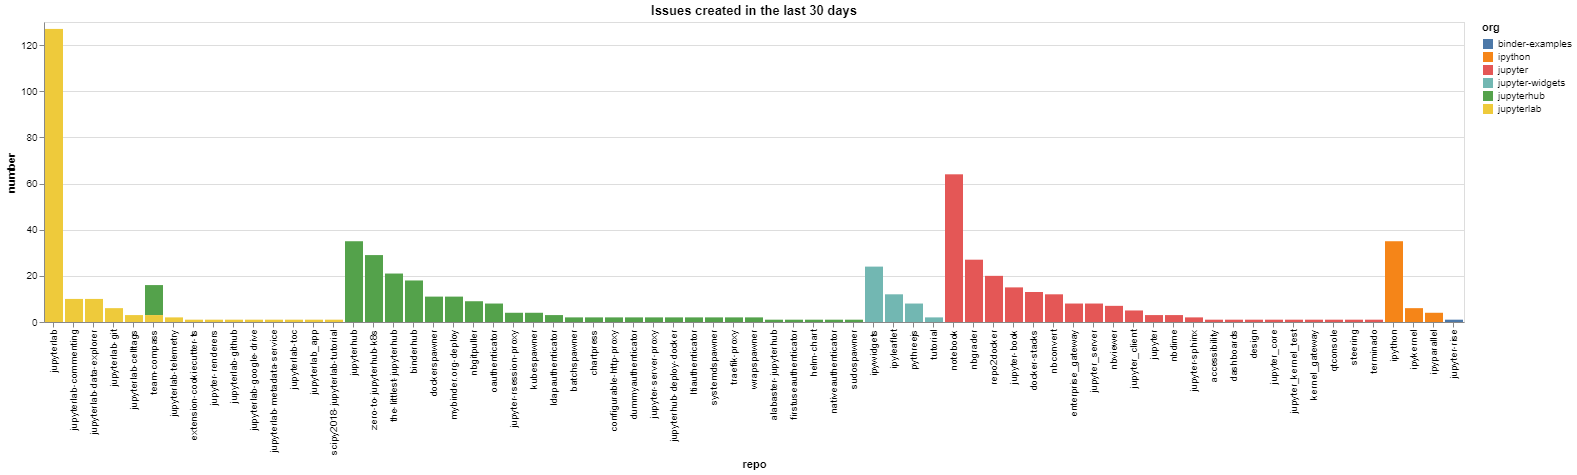

In [34]:
created_counts = created.groupby(['org', 'repo']).count()['number'].reset_index()
created_counts['org/repo'] = created_counts.apply(lambda a: a['org'] + '/' + a['repo'], axis=1)
sorted_vals = created_counts.sort_values(['org', 'number'], ascending=False)['repo'].values
alt.Chart(data=created_counts, title="Issues created in the last 30 days").mark_bar().encode(
    x=alt.X('repo', sort=alt.Sort(sorted_vals.tolist())),
    y='number',
    color='org',
)

In [35]:
responses = []
for org in orgs:
    query_prs = f"is:issue user:{org} closed:{start_date}..{end_date}"
    ghq = GitHubGraphQlQuery(query_prs)
    ghq.request()
    if ghq.data is None:
        continue
    responses.append(ghq)
    
closed = pd.concat([ii.data for ii in responses])
closed['n_comments'] = closed['comments'].map(lambda a: len(a['edges']))

Found 141 items, which will take 3 pages
Found 233 items, which will take 5 pages
Found 216 items, which will take 5 pages
Found 50 items, which will take 1 pages
Found 33 items, which will take 1 pages
Found 1 items, which will take 1 pages


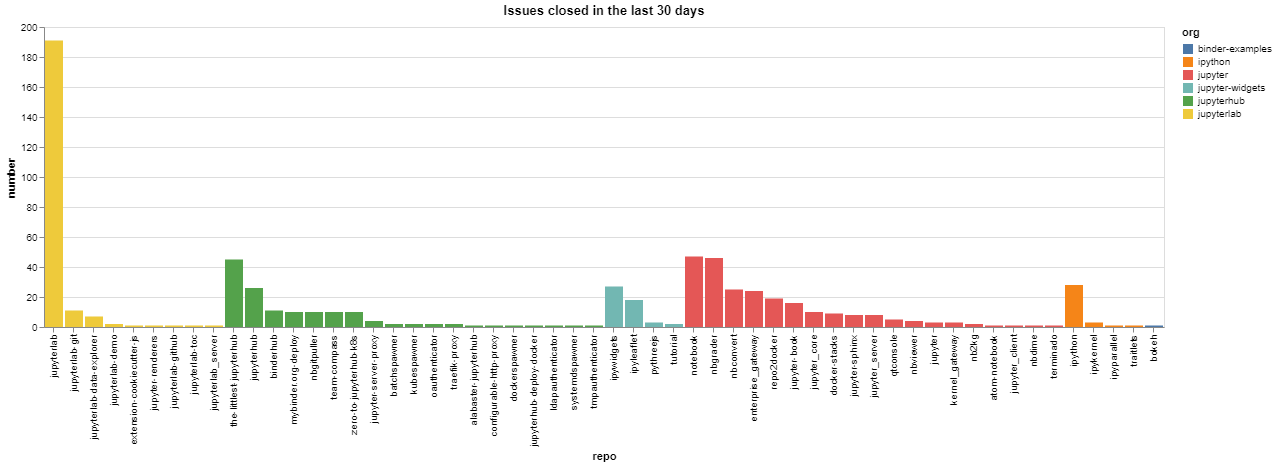

In [36]:
closed_counts = closed.groupby(['org', 'repo']).count()['number'].reset_index()
closed_counts['org/repo'] = closed_counts.apply(lambda a: a['org'] + '/' + a['repo'], axis=1)
sorted_vals = closed_counts.sort_values(['org', 'number'], ascending=False)['repo'].values
alt.Chart(data=closed_counts, title="Issues closed in the last 30 days").mark_bar().encode(
    x=alt.X('repo', sort=alt.Sort(sorted_vals.tolist())),
    y='number',
    color='org',
)

### A list of recent issues

In [37]:
n_plot = 5
tabs = widgets.Tab(children=[])
for ii, (org, idata) in enumerate(created.groupby('org')):
    issue_md = []
    issue_md.append(f"#### {org}")
    issue_md.append("")
    for (org, repo), issues in idata.groupby(['org', 'repo']):
        issue_md.append(f"##### [{org}/{repo}](https://github.com/{org}/{repo})")
        for _, issue in issues.sort_values('n_comments', ascending=False).head(n_plot).iterrows():
            user_name = issue['username']
            user_url = issue['username_url']
            issue_number = issue['number']
            issue_html = issue['url']
            issue_title = issue['title']

            text = f"* [(#{issue_number})]({issue_html}): _{issue_title}_ by **[@{user_name}]({user_url})**"
            issue_md.append(text)
    issue_md.append('')
    md_html = HTML(markdown('\n'.join(issue_md)))
    
    children = list(tabs.children)
    children.append(HTML(markdown('\n'.join(issue_md))))
    tabs.children = tuple(children)
    tabs.set_title(ii, org)
    
display(Markdown(f"Here are the top {n_plot} active issues in each repository in the last 30 days"))
display(tabs)

Here are the top 5 active issues in each repository in the last 30 days

## Commenters across repositories

In [38]:
comments = []
for items in [created, merged, closed]:
    for ii, irow in items.iterrows():
        icomments = [ii['node'] for ii in irow['comments']['edges']]
        icomments = pd.DataFrame(icomments)
        icomments['repo'] = irow['repo']
        icomments['org'] = irow['org']
        comments.append(icomments)
comments = pd.concat(comments)
comments = comments.query("createdAt > @start_date and createdAt < @end_date")
comments['username'] = comments['author'].map(lambda a: a['login'])
comments['username_url'] = comments['author'].map(lambda a: a['url'])

/home/choldgraf/anaconda/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [39]:
commentors = (
    comments
    .groupby(['org', 'repo', 'username'])
    .count()['author']
    .reset_index()
    .sort_values(['org', 'author'], ascending=False)
)

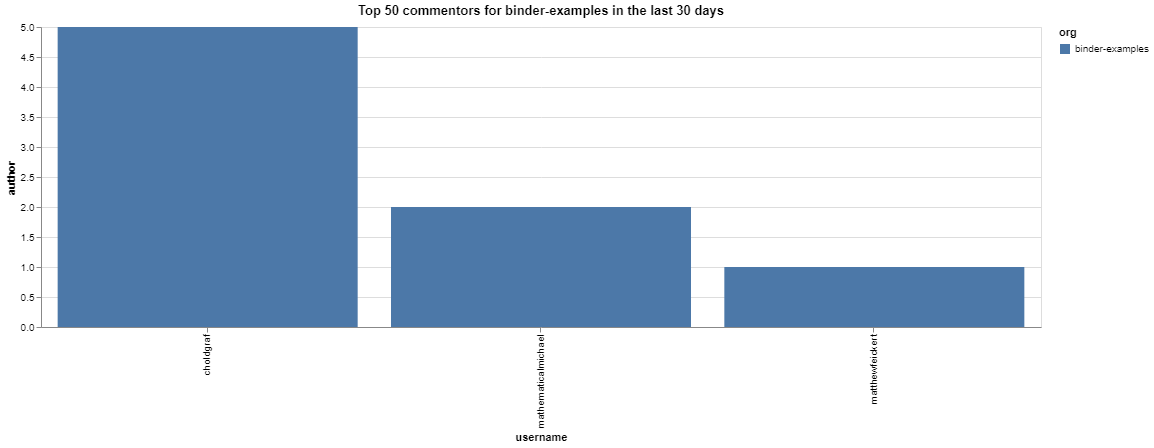

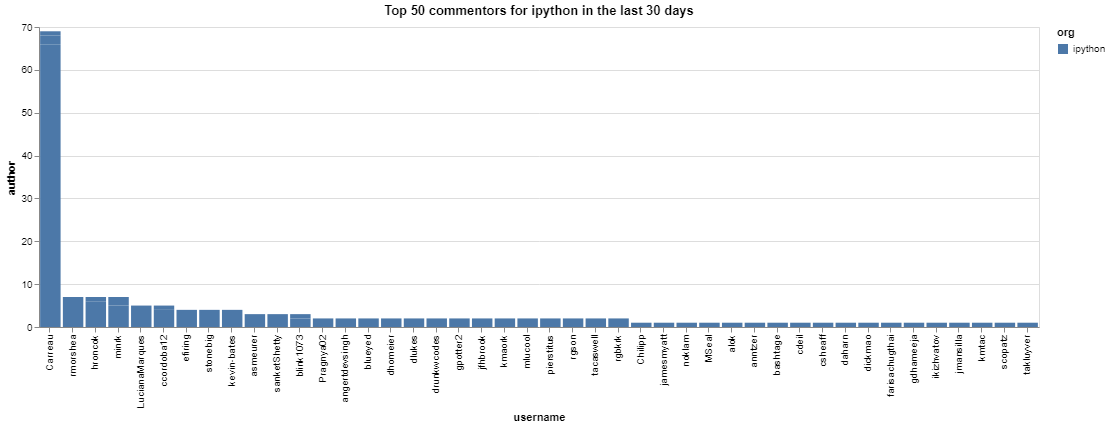

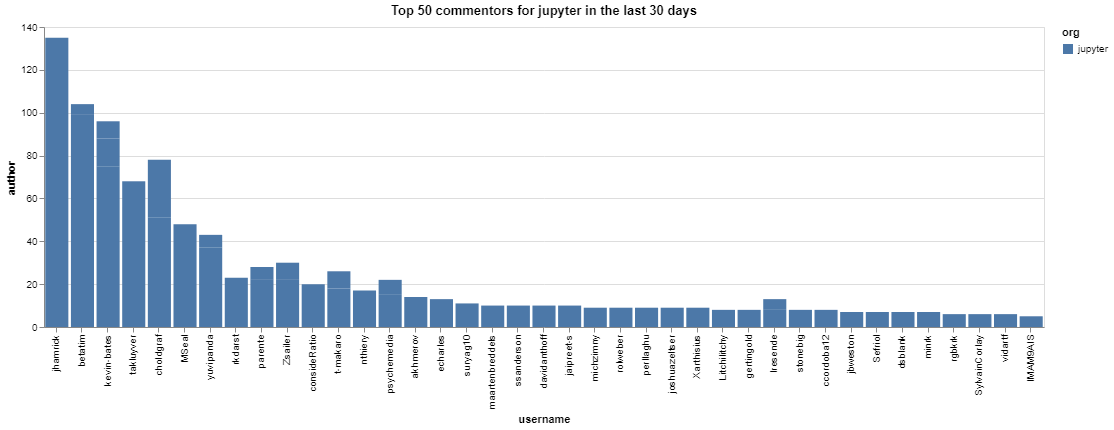

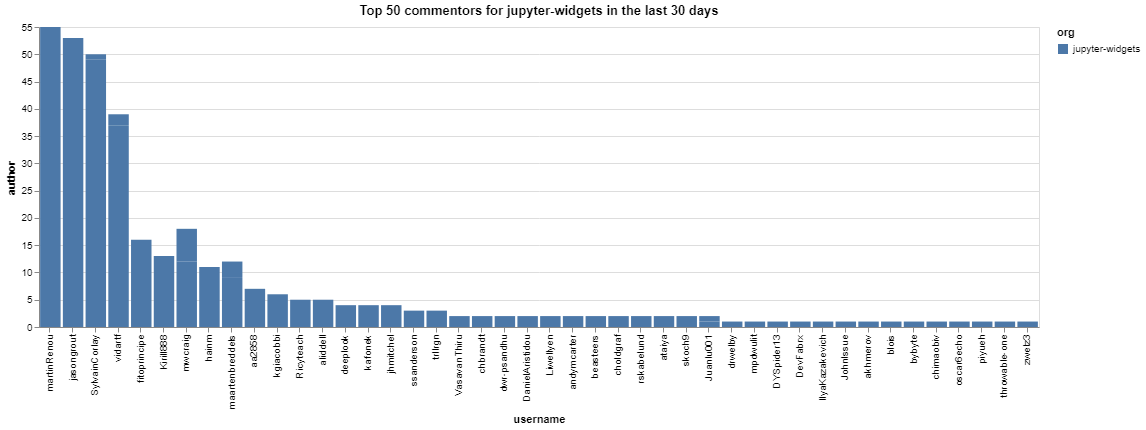

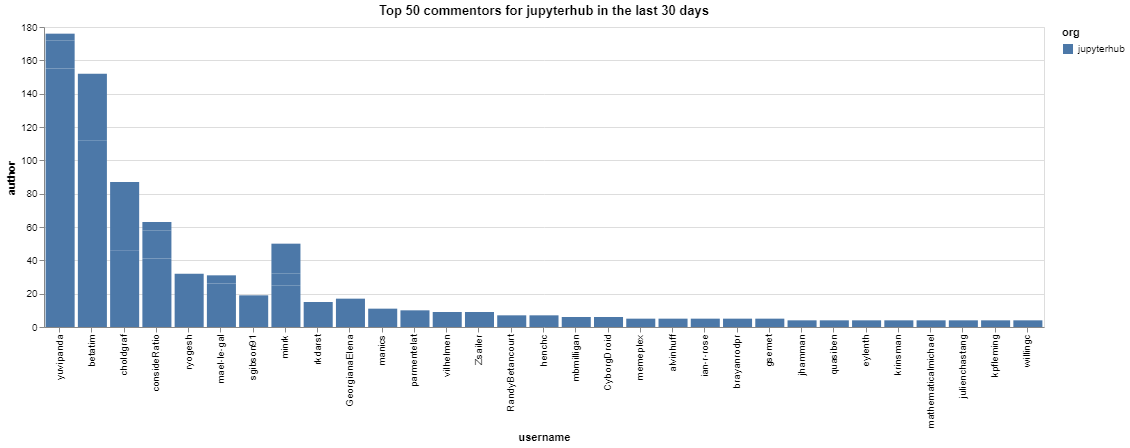

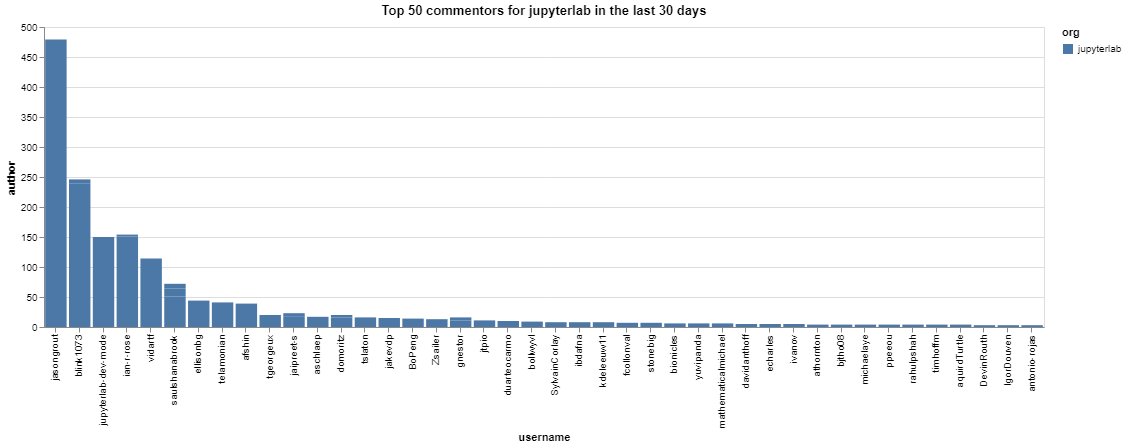

In [55]:
for iorg, idata in commentors.groupby(['org']):
    title = f"Top 50 commentors for {iorg} in the last 30 days"
    ch = alt.Chart(data=idata.head(50), width=1000, title=title).mark_bar().encode(
        x=alt.X('username', sort=alt.Sort(idata['username'].tolist())),
        y='author',
        color='org',
    )
    display(ch)

In [41]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>